[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/samgdotson/osier/env-instructions?labpath=docs%2Fsource%2Fexamples%2Fdispatch_tutorial.ipynb)

# Dispatch Tutorial

In this tutorial you will learn how to run a dispatch model in `osier` using

1. `osier` technology objects

2. The `osier` dispatch algorithm

A dispatch model determines the amount of energy each technology produces at each timestep. This implementation uses a linear program constructed with `Pyomo`. Since it is a linear program, the model has perfect foresight and 
minimizes total variable cost.

First, we must import some key ingredients.

In [1]:
# basic imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW
import sys

# osier imports
from osier import DispatchModel, LogicDispatchModel
import osier.tech_library as lib


# automatically set the solver
if "win32" in sys.platform:
    solver = 'cplex'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cbc


## Creating the technology portfolio

In order to run a dispatch model you must provide a mix of energy generating technologies. The technologies used in the dispatch model should be added to a python `list`. 

In general, **dispatch models do not optimize the capacity of each generator.** They only optimize the amount of energy each generator produces (i.e., dispatches). 

If you forget what technologies are available in `osier` (or what they're called), simply look at the catalog!

In [2]:
lib.catalog()

,Import Name,Technology Name
0,battery,Battery
1,biomass,Biomass
2,coal,Coal_Conv
3,coal_adv,Coal_Adv
4,natural_gas,NaturalGas_Conv
5,natural_gas_adv,NaturalGas_Adv
6,nuclear,Nuclear
7,nuclear_adv,Nuclear_Adv
8,solar,SolarPanel
9,wind,WindTurbine


In [3]:
# create a capacity portfolio of only natural gas.

technology_mix = [lib.natural_gas]
display(technology_mix)

[NaturalGas_Conv: 8375.1331 MW]

## Adding energy demand

The other thing a dispatch model needs in order to run is a demand profile to optimize. We will create a dummy demand profile for a 48-hour period for our model to optimize.

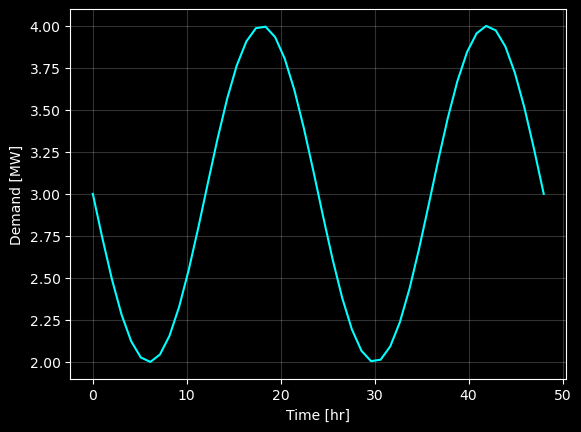

In [4]:
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.show()

The demand peaks in the afternoon and reaches a minimum around 6 A.M. Although reasonable, we could make it slightly more "realistic" by adding some random noise. We can also adjust curve so the area under the curve matches a known amount of demand.

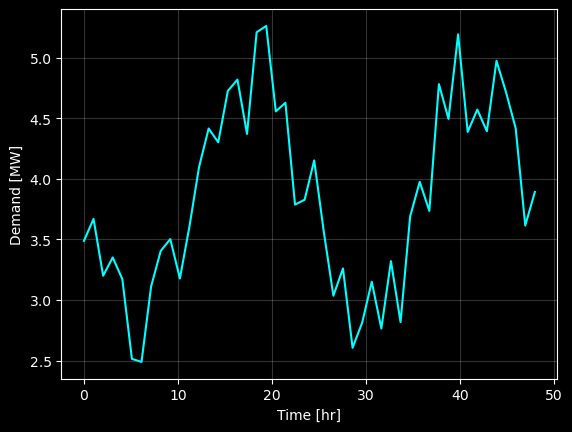

In [5]:
total_demand = 185  # [MWh], sets the total demand [units of energy]
demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.show()

## Creating the Dispatch Model


This is the simplest model in `osier`. The dispatch model minimizes total operational cost of the system and requires two pieces of data:

1. A list of `osier.Technology` objects that can meet the specified demand.

2. A **net** demand profile (i.e., if you want to model renewable energy, you should provide a production curve for the given time period of interest). The net demand is the demand minus the non-dispatchable energy production at each time step (e.g., demand - wind production - solar production). 

In order to solve the model, simply call `DispatchModel.solve(solver="SOLVER_NAME")`. This function returns `None`, but you can check that it succeeded by printing `DispatchModel.objective`.

The default values for the model are:

1. Energy -- Megawatts [MW]

2. Time -- 1 hour [hr]

3. Cost -- million dollars per unit [M$/unit]

In [6]:
import time
start = time.perf_counter()
model = DispatchModel(technology_list=technology_mix,
                      net_demand=demand
                     )
model.solve(solver=solver)  # add your preferred solver here!
end = time.perf_counter()
print(model.objective)
print(f"Model ran in {(end-start):3f} seconds.")

0.0041415950022387
Model ran in 0.843126 seconds.


## Verifying the results

Since this is only a dispatch model, the only costs that contribute to the merit order is the marginal cost of producing electricity (i.e., the variable costs). Although there are two types of variable costs in an `osier.Technology` object, fuel and operating and management (O&M). They are automatically combined into a single variable cost (`osier` tries to enforce consistent units as well by using the `unyt` library).

In order to verify that the results make sense, we can divide the model objective by the total demand, and that should equal the variable cost for the natural gas technology (though I use the `np.isclose` command to account for any floating point wonkiness).

In [7]:
tol = 1e-6
np.isclose((model.objective / total_demand), 
           model.technology_list[0].variable_cost, 
           rtol=tol)

np.True_

The variables agree! Which means the model ran successfully and nothing strange happened!

## Checking the results

In [8]:
# show the first 5 hours of the system.
model.results.head()

,NaturalGas_Conv,Curtailment,Cost
0,3.487598,-0.0,0.000078
1,3.669428,-0.0,0.000082
2,3.199753,-0.0,0.000072
3,3.351018,-0.0,0.000075
4,3.172340,-0.0,0.000071


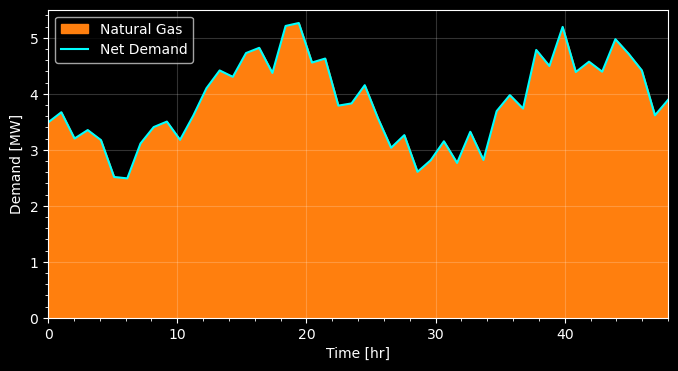

In [9]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['NaturalGas_Conv'].values, 
                    color='tab:orange', 
                    label='Natural Gas')
    ax.plot(hours, model.net_demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    ax.set_ylim(0,5.5)
    ax.legend()
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()

We see that the natural gas plant perfectly fulfilled the demand at each time step.

## Hierarchical Dispatch

`osier` offers a second, faster, dispatch algorithm called
`osier.LogicDispatchModel`. Although this model is faster, it is myopic.
Therefore, optimality is not guaranteed. Especially for systems with a lot of
renewable energy and battery storage.

`LogicDispatchModel` can be used as a drop-in replacement for the original `DispatchModel`.

In [10]:
start = time.perf_counter()
model = LogicDispatchModel(technology_list=technology_mix,
                      net_demand=demand
                     )
model.solve()  # add your preferred solver here!
end = time.perf_counter()
print(model.objective)
print(f"Model ran in {(end-start):3f} seconds.")

0.0041415950000000005
Model ran in 0.101489 seconds.


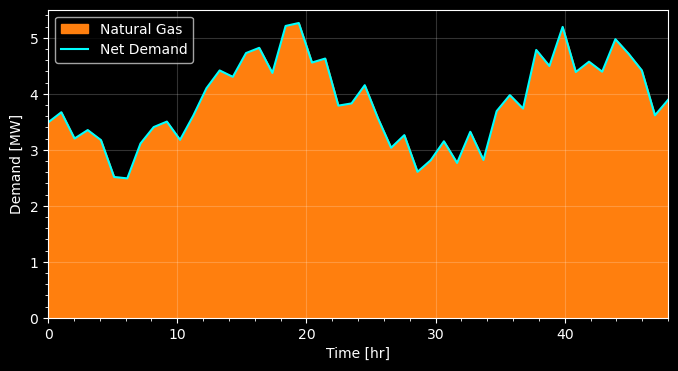

In [11]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['NaturalGas_Conv'].values, 
                    color='tab:orange', 
                    label='Natural Gas')
    ax.plot(hours, model.net_demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    ax.set_ylim(0,5.5)
    ax.legend()
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()

## Time Benchmarking

In [12]:
%%timeit
model = DispatchModel(technology_list=technology_mix,
                      net_demand=demand
                     )
model.solve(solver=solver)

955 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
model = LogicDispatchModel(technology_list=technology_mix,
                      net_demand=demand
                     )
model.solve() 

264 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We observe almost a 4x speed-up using the `LogicDispatchModel` over the
`DispatchModel`.